# PCA, Clustering, and Logistic Regression with MNIST

In this project, I use MNIST data for some experiments using PCA, spectral clustering, and logistic regression.
Some functions are computed manually rather than using built-in variants as a coding exercise.

In [1]:
#import libraries, set seed for replicability
from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from warnings import filterwarnings
from numpy.linalg import norm
import scipy.spatial.distance as ssd
import pylab as py


np.random.seed(seed=123)

In [2]:
data, labels = fetch_openml('mnist_784', version=1, return_X_y=True)
randperm = np.random.permutation(data.shape[0])
data = data[randperm]
labels = labels[randperm]

Next, I plot some samples of MNIST data to confirm random ordering,

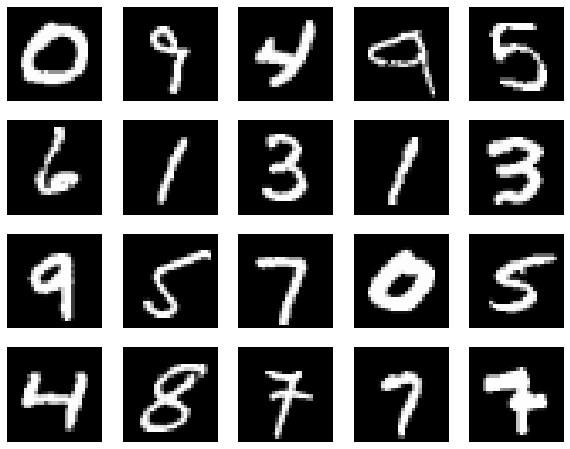

In [3]:
%matplotlib inline
data = np.divide(data,255)

subset = data[0:24,]
nrows = 4
ncols = 5
plt.figure(figsize=(ncols*2, nrows*2))
for i in range(nrows*ncols):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(subset[i].reshape((28,28)), cmap='gray')
    plt.axis('off')
plt.axis('off')
plt.show()

In [19]:
# split data into train, validate, test
pd_data = pd.DataFrame(data)
pd_data['labels'] = labels
train, dev, test = np.split(pd_data.sample(frac=1, random_state = 15), [int(.6*len(pd_data)), int(.8*len(pd_data))])
#remove label from datasets for easier plotting later on
train_a = train.drop(columns = 'labels')
test_a = test.drop(columns = 'labels')
dev_a = dev.drop(columns = 'labels')

print(train_a.shape)
print(dev_a.shape)
print(test_a.shape)

(42000, 784)
(14000, 784)
(14000, 784)


## Creating PCA 

I construct a PCA using an eigendecomposition of the sample covariance matrix and plot the top 10 principal components. They look like contours around commonly drawn on areas of the image.

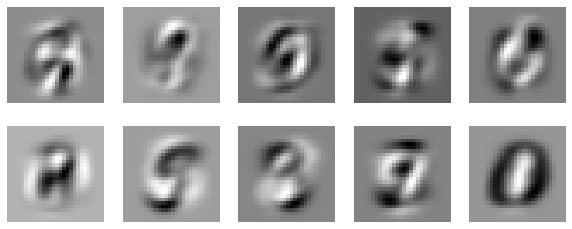

In [5]:
#compute PCA for training dataset
train_demean = (train_a-train_a.mean()).to_numpy()
n = train_demean.shape[0]
S=np.matmul(np.transpose(train_demean),train_demean)/n
e,v = np.linalg.eigh(S)

#collect top 10 values and plot
top_10 = v[:,-10:]
nrows =2
ncols = 5
plt.figure(figsize=(ncols*2, nrows*2))
for i in range(nrows*ncols):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(top_10[:,i].reshape((28,28)), cmap='gray')
    plt.axis('off')
plt.axis('off')
plt.show()

Below, I plot the eigenvalues in decreasing order. This is equivalent to plotting the variances of the principal components.

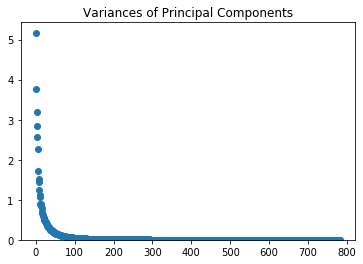

In [6]:
plt.scatter(np.arange(784), sorted(e)[::-1])
plt.title("Variances of Principal Components")
plt.ylim([e.min(),1.05*e.max()])
plt.show()

I take four data points and plot the principal component projection for the top 5/10/50/100 principal components. Lastly, I plot the raw image. We see that the largest principal components capture contours around commonly used parts of the image. As we increase the number of PC's, the effective resolution gets sharper and the common curves to most images disappear if they aren't on the particular digit. Additional PC's capture parts of the image that are successively less central to the shape of the digit.

We can barely identify with 5 PCs, and we get a fairly good estimation with 50 PCs. With 100, its almost as good as the original image.

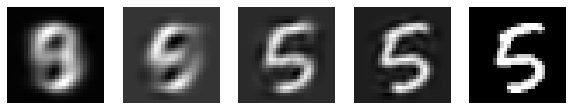

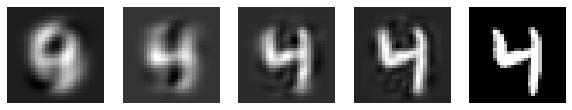

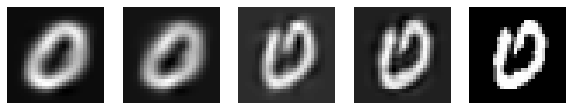

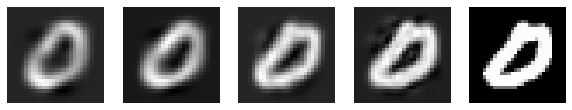

In [7]:
# plot approximations of samples for increasing number of PC's

#generate list of datasets of images
pca_graph = []
for m in [5,10,50,100]:
    pca_data = np.dot(test_a - train_a.mean(), v[:,-m:])
    pca_inverse = pd.DataFrame(np.dot(pca_data, v[:,-m:].T))+train_a.mean()
    pca_graph.append(pca_inverse.to_numpy())
pca_graph.append(test_a.to_numpy())

#Plot progression of images across dataset
nrows = 1
ncols = 5
for j in [4,22,698,1939]:
    plt.figure(figsize=(ncols*2, nrows*2))
    for i in range(nrows*ncols):
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(pca_graph[i][j].reshape((28,28)), cmap='gray')
        plt.axis('off')
    plt.axis('off')
    plt.show()

# K Means

In [8]:
# fit kmeans
model = KMeans(n_clusters=10, max_iter = 50, random_state = 10)
pred = model.fit_predict(train_a)

Next I plot each cluster center. Ideally, these would be different digits.

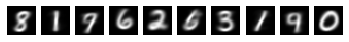

In [9]:
#show k means cluster centers
for i in range(10):
    plt.subplot(1,10, i+1)
    plt.imshow(model.cluster_centers_[i].reshape((28,28)), cmap='gray')
    plt.axis('off')
plt.axis('off')
plt.show()

I output the average error of the clusters based on the labels. We see it has a pretty high error. This basic method of clustering likely doesn't work very well.

In [10]:
# report average accuracy
train_cluster = train.copy()
train_cluster['prediction'] = pred
train_cluster['majority_label'] = train_cluster.groupby(['prediction'])['labels'].transform(lambda x: x.mode().iloc[0])
print("Training Cluster Error")
print(sum(train_cluster['majority_label']!=train_cluster['labels'])/train_cluster.shape[0])

Training Cluster Error
0.41354761904761905


I plot some examples from each cluster below, in order of the cluster. The respective cluster majority label for each column is given beneath the sample images. We see the digits get easily mixed up when they share common lines/curves.

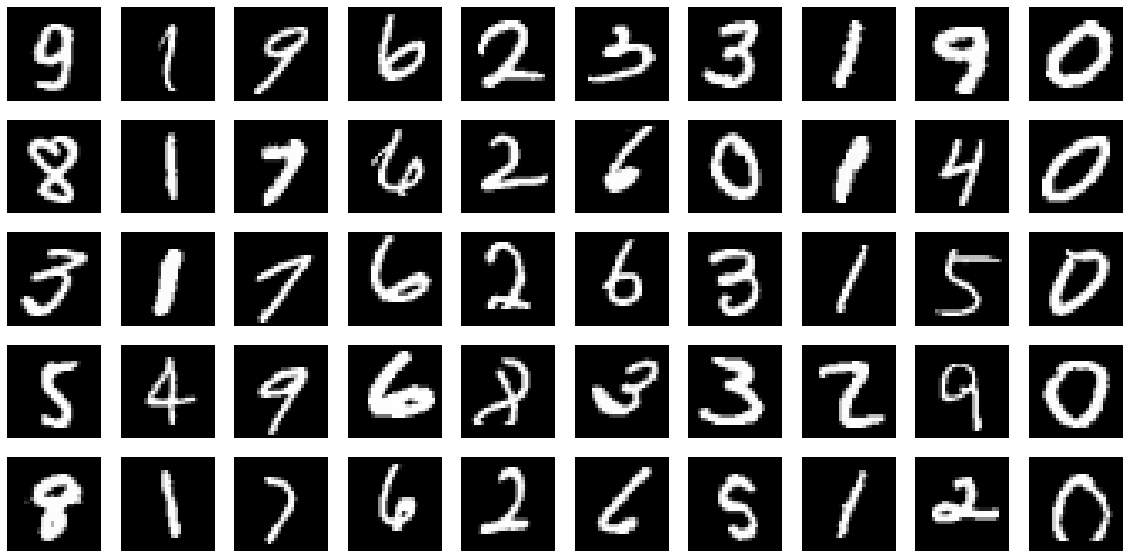

prediction
0    8
1    1
2    7
3    6
4    2
5    6
6    3
7    1
8    4
9    0
Name: labels, dtype: object

In [11]:
#plot cluster samples
nrows = 5
ncols = 10
plt.figure(figsize=(ncols*2, nrows*2))
for i in range(ncols):
    sample = train_a[pred==i].sample(n=5, random_state=1).to_numpy()
    for j in range(nrows):
        plt.subplot(nrows, ncols, 10*j+i+1)
        plt.imshow(sample[j].reshape((28,28)), cmap='gray')
        plt.axis('off')
plt.axis('off')
plt.show()
#plot corresponding labels
display(train_cluster.groupby(['prediction'])['labels'].agg(pd.Series.mode))

# Spectral Clustering

I run spectral clustering for h = 30. 30 tends to fit the data well.

In [12]:
#get a subset of the training data
sub_train1, sub_train2 = np.split(train.sample(frac=1, random_state = 30), [int(.15*len(train))])
sub_train_matrix = sub_train1.drop(columns = "labels").to_numpy()
#use pdist to compute pairwise distances
W_norms = np.square(ssd.squareform(ssd.pdist(sub_train_matrix, 'euclidean')))
W_30 = np.exp(-1*W_norms/30)

#functions to compute laplacian
def diag1(old_matrix):
    D = np.zeros(old_matrix.shape)
    row,col= np.diag_indices_from(D)
    D[row,col] = np.reciprocal(np.sqrt(old_matrix.sum(axis=1)))
    return D

def laplac(W_in):
    D = diag1(W_in)
    L = np.identity(W_in.shape[0]) - np.dot(np.dot(D,W_in),D)
    return L

L_30 = laplac(W_30)
e_30,v_30 = np.linalg.eigh(L_30)

Next I make two plots. The first is the first two eigenvectors colored by true label. The second is the eigenvectors colored by cluster label. We see the cluster differentiates 0 from 1 well, but 2 has some overlap with both which makes sense given the shapes of the three digits.

I write a function to embed a new point and then embed some 0's.

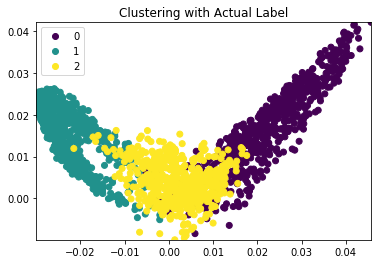

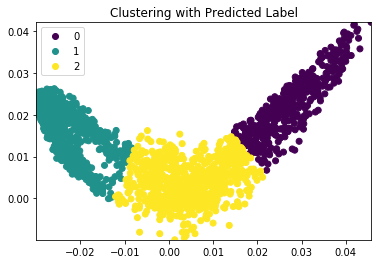

In [13]:
filterwarnings('ignore')

#plot the two eigenvectors and run k means on them. plot result of kmeans
sub_train1['v1'] = v_30[:,1]
sub_train1['v2'] = v_30[:,2]

#plot by predicted cluster
subset_plot = sub_train1[sub_train1['labels'].isin(('0','1','2'))]
subset_plot['labels'] = subset_plot['labels'].astype(int)
subset_plot = subset_plot.sort_values(['labels'])
scatter = plt.scatter(subset_plot['v1'], subset_plot['v2'], c = subset_plot['labels'].astype(int))
plt.axis([min(subset_plot['v1']), max(subset_plot['v1']), min(subset_plot['v2']), max(subset_plot['v2'])])
plt.legend(handles=scatter.legend_elements()[0], labels=['0','1','2'])
plt.title("Clustering with Actual Label")
plt.show()


#plot true value
model = KMeans(n_clusters = 3, max_iter = 50, random_state = 10)
pred = model.fit_predict(subset_plot[['v1','v2']])
subset_plot['pred'] = pred
subset_plot['pred_label'] = subset_plot.groupby('pred')['labels'].transform('median') #technically want mode but median works in basic case
subset_plot = subset_plot.sort_values(['pred_label'])
scatter = plt.scatter(subset_plot['v1'], subset_plot['v2'], c = subset_plot['pred_label'])
plt.axis([min(subset_plot['v1']), max(subset_plot['v1']), min(subset_plot['v2']), max(subset_plot['v2'])])
plt.legend(handles=scatter.legend_elements()[0], labels=['0','1','2'])
plt.title("Clustering with Predicted Label")
plt.show()

In [14]:
#embed new point in spectral clustering
def embed_point(new, old):
    W_temp = np.exp(-1*np.square(ssd.cdist(new[np.newaxis,:], old, 'euclidean'))/30) #distance from point to all old points
    sum_old = W_30.sum(axis=1)
    sum_new = W_temp.sum(axis=1)
    for i in range(W_temp.shape[1]):
        W_temp[0,i] = W_temp[0,i]/(np.sqrt(sum_new)*np.sqrt(sum_old[i]))
    
    return(np.divide(np.dot(W_temp,v_30[:,1:3]),e_30[1:3]))
    
# get a subset of 0s and embed them    
subset_test = test[test['labels']=='0'].drop(columns = ['labels']).sample(frac = .1, random_state = 10)
embedding = subset_test.apply(lambda row: embed_point(row,sub_train_matrix), axis = 1)
embeds = np.array([x[0] for x in embedding])

I'm going to take a few zero's that were not used for clustering and see where they fall once embedded.

We find that the new zeros fall above the old zeros with some overlap on the 2's but still in the domain of the original 0s. This seems to indicate that the embedding does an ok job so that the testing result roughly matches the training result.

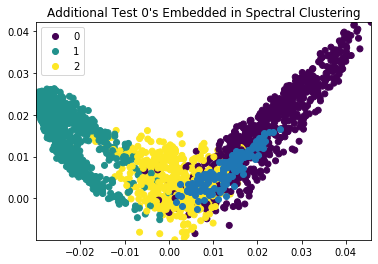

In [15]:
#plot subset of 0's 
scatter=plt.scatter(subset_plot['v1'], subset_plot['v2'], c = subset_plot['labels'])
plt.axis([min(subset_plot['v1']), max(subset_plot['v1']), min(subset_plot['v2']), max(subset_plot['v2'])])
plt.scatter(embeds[:,0], embeds[:,1])
plt.legend(handles=scatter.legend_elements()[0], labels=['0','1','2'])
plt.title("Additional Test 0's Embedded in Spectral Clustering")
plt.show()


# Logistic 

I fit a logistic regression to the training data and test on the development data for different possible numbers of principal components to use. I also compare this against a regrssion using the raw data. Note: there was additional work that included the test set. Code has been removed to shorten the project.

Classification Error on Non-PCA Raw Data
0.0825


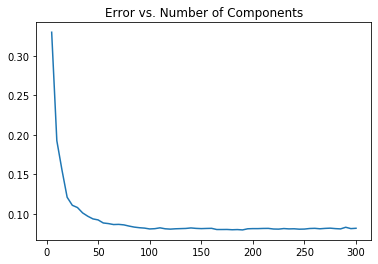

Number of Components that Minimizes Error
190.0


In [16]:
#run logistic and find k that minimizes error for pc
filterwarnings('ignore')
    
lg=LogisticRegression(fit_intercept=True, C=100000, penalty='l2',multi_class='multinomial',solver='lbfgs')

lg.fit(train_a,train['labels'])
pred_1 = lg.predict(dev_a)
print("Classification Error on Non-PCA Raw Data")
print(sum(pred_1!=dev['labels'])/pred_1.shape[0])

num_k = 305
error=np.empty((60,2))
ind = 0
for k in range(5,num_k,5): #iterate by 5
    pca_data = np.dot(train_a - train_a.mean(), v[:,-k:])
    pca_test = np.dot(dev_a - train_a.mean(), v[:,-k:])
    lg.fit(pca_data,train['labels'])
    pred = lg.predict(pca_test)
    error[ind,1] = sum(pred!=dev['labels'])/pred.shape[0]
    error[ind,0] = k
    ind = ind+1

plt.plot(error[:,0], error[:,1])
plt.title("Error vs. Number of Components")
plt.show()
min_k = error[error[:,1].argmin(),0]
print("Number of Components that Minimizes Error")
print(min_k)
print("Min Error")
print(error.min())

#additional work with Test Set Excluded after this point.